In [1]:
# Import general packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import special packages
import cv2

In [3]:
from modules.parser import Parser
import os

ROOT = "annotated_dataset/non_ideal_coco_annotations"
annotation_path = "annotations/instances_default.json"
image_path = "images"

parser = Parser(os.path.join(ROOT, annotation_path))
data = parser.group_annotations_by_image()
image_meta = parser.get_images()

In [18]:
def get_rects(image):
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    rects = selective_search.process()
    return rects

In [19]:
!pip install -q tqdm

In [21]:
from tqdm import tqdm

image_names = list(data.keys())
output_folder = "data"
target = "true"
false_target = "false"

k = 1
target_shape = (224, 224)
for i in tqdm(range(len(image_names))):
    file_name = os.path.join(ROOT, image_path, image_meta[i]["file_name"])
    annotations = [annot["bbox"] for annot in data[image_names[i]]]
    
    image = cv2.imread(file_name)
    rects = get_rects(image)
    for i in range(len(annotations)):
        x1, y1, width, height = np.asarray(annotations[i], dtype=np.int32)  # format: (start_x, start_y, width, height)
        x2 = x1 + width
        y2 = y1 + height
        # true RoI
        roi = image[y1:y2, x1:x2]
        roi = cv2.resize(roi, target_shape)
        filename = str(k) + ".jpg"
        cv2.imwrite(os.path.join(output_folder, target, filename), roi)

        # false RoI
        m = 0
        for each_rect in rects:
            rx1, ry1, rx2, ry2 = each_rect
            rx2 = rx1 + rx2
            ry2 = ry1 + ry2
            box1 = {"x1": x1, "y1": y1, "x2": x2, "y2": y2} # true annotation
            box2 = {"x1": rx1, "y1": ry1, "x2": rx2, "y2": ry2} # true annotation
            iou = intersection_over_union(box1, box2)
            # if IoU == 0.0, its a totally false image
            if iou == 0.0:
                if m != 5:
                    false_roi = image[ry1:ry2, rx1:rx2]
                    false_roi = cv2.resize(false_roi, target_shape)
                    filename = str(k) + "_" + str(m) + ".jpg"
                    cv2.imwrite(os.path.join(output_folder, false_target, filename), false_roi)
                    m += 1
        k += 1

print(f"Exported {k} RoI(s)")

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [51:58<00:00, 15.29s/it]

Exported 408 RoI(s)


## Proposing false images

In [12]:
cv2.setUseOptimized(True)
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [8]:
def intersection_over_union(box1, box2):
    assert box1['x1'] < box1['x2']
    assert box1['y1'] < box1['y2']
    assert box2['x1'] < box2['x2']
    assert box2['y1'] < box2['y2']

    x_left = max(box1['x1'], box2['x1'])
    y_top = max(box1['y1'], box2['y1'])
    x_right = min(box1['x2'], box2['x2'])
    y_bottom = min(box1['y2'], box2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

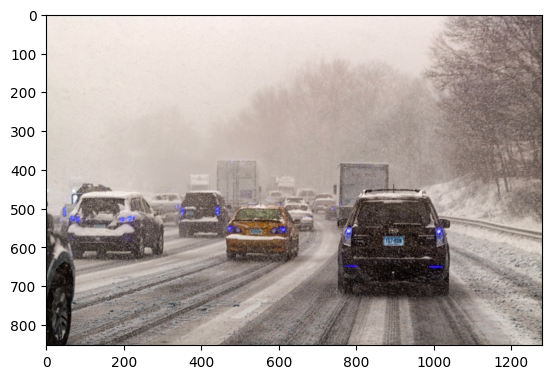

In [10]:
plt.imshow(image)

## Avoiding duplicate False images

In [2]:
path = "data\\false\\"

images = []

for i in os.listdir(path):
    image = cv2.imread(os.path.join(path, i))
    images.append(image)

images = np.asarray(images)

In [4]:
flattened_arrays = images.reshape(images.shape[0], -1)
# Find unique flattened arrays
unique_indices = np.unique(flattened_arrays, axis=0, return_index=True)[1]
# Keep only the unique arrays
unique_arrays = images[unique_indices]

In [5]:
print(images.shape)
print(unique_arrays.shape)

(1974, 224, 224, 3)
(1162, 224, 224, 3)


In [6]:
output_folder = "data\\false_unique"

for i in range(len(unique_arrays)):
    cv2.imwrite(os.path.join(output_folder, str(i + 1) + ".jpg"), unique_arrays[i])